## Post Processing
GTやFuel Demandの部分についての汎用化を行うために"GT_heatrate"と"Add_Fuel_Demand"について条件を振ったデータセットの再構築を行う。  
新しいデータセットを作るにあたっては以下2通りを検討した。
- Case1 元データセットをすべての組み合わせ　× 指定した"GT_heatrate"と"Add_Fuel_Demand"のすべての組み合わせ
- Case2 元データセットからランダム抽出 ＋ "GT_heatrate"と"Add_Fuel_Demand"をランダム抽出  
のちのBest Parameter算出の検証において、Case2ではうまくピークが得られなかったため、Case1を採用することになった。

### ライブラリー、モデル、データセットの読み込み

In [1]:
import sys, os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import *
import gc
from tqdm import tqdm #時間表示用

pd.set_option('display.max_columns', 200) #df表示数増加

In [ ]:
# # データセットの読み込み
# path = '../output/dataset_preprocessed.pkl'
# df_raw = pd.read_pickle(path)
# df_raw.reset_index(inplace=True, drop=True) 
# print("df_raw.shape:", df_raw.shape)

In [3]:
# データのファイル数をカウント
data_dir = '/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/preprocessed/csv'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print(file_num)

# データを読み込み、1つのDataframeに結合
df_raw = pd.DataFrame()  # 最終的にまとめるDataframe
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    df_tmp = pd.read_csv(file_dir) #read_pickle
    df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)  # 行のIndexをリセット
print(df_raw.shape)
print("duplicates:", df_raw.duplicated().sum())  # 重複行がないか確認

12
(137772, 123)
duplicates: 0


In [ ]:
# # Pre-processing: UA Extraction
# df_raw_temp = df_raw.copy()
# df_raw = df_raw[(df_raw['WB_UA'] > 1.5 * 10**7) & (df_raw['WB_UA'] < 6 * 10**7)]
# df_raw = df_raw[(df_raw['CB_UA'] > 0.75 * 10**6) & (df_raw['CB_UA'] < 3 * 10**6)]
# df_raw.reset_index(inplace=True, drop=True) # Indexを振りなおす

# df_raw.describe()

UA抽出結果 

データ数 137772 → 71383 

WB_UA 最小値:  1.00e+07 → 1.50e+07
WB_UA 最頻値:  3.35e+07 → 3.35e+07
WB_UA 中央値:  3.85e+07 → 3.27e+07
WB_UA 平均値:  4.66e+07 → 3.44e+07
WB_UA 最大値:  1.50e+08 → 6.00e+07 

CB_UA 最小値:  1.15e+05 → 7.50e+05
CB_UA 最頻値:  1.39e+06 → 1.39e+06
CB_UA 中央値:  1.69e+06 → 1.51e+06
CB_UA 平均値:  2.22e+06 → 1.62e+06
CB_UA 最大値:  1.00e+07 → 3.00e+06 



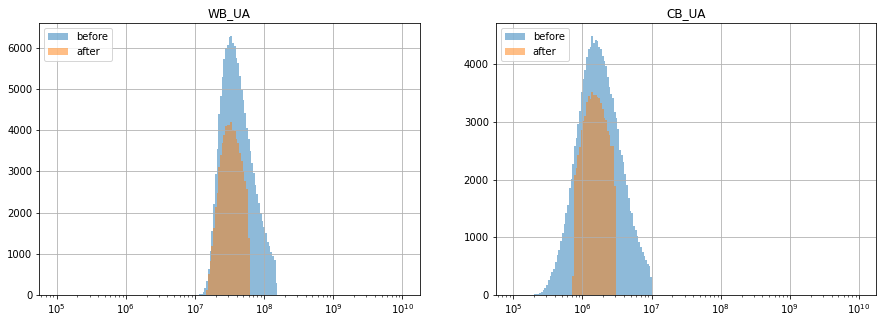

In [4]:
# Pre-processing_2 UA Extraction
UA_list = ['WB_UA', 'CB_UA']

df_raw_temp = df_raw.copy()

# UAの外れ値を除外
df_raw = df_raw[(df_raw['WB_UA'] > 1.5 * 10**7) & (df_raw['WB_UA'] < 6 * 10**7)]
df_raw = df_raw[(df_raw['CB_UA'] > 0.75 * 10**6) & (df_raw['CB_UA'] < 3 * 10**6)]
df_raw.reset_index(inplace=True, drop=True) # Indexを振りなおす

print("UA抽出結果","\n")
print("データ数", df_raw_temp.shape[0], "→", df_raw.shape[0],"\n")

# 可視化
num_row = math.ceil(len(df_raw.loc[:, UA_list].columns) / 2)

plt.figure(figsize=(15, 5 * num_row))
i = 0

for tag in df_raw.loc[:, UA_list].columns:
    i += 1
    plt.subplot(num_row, 2, i)
    n_raw, bins_raw, patches_raw = plt.hist(x=df_raw_temp[tag], bins=np.logspace(5, 10, 200), alpha=0.5, label="before")
    n, bins, patches = plt.hist(df_raw[tag], bins=np.logspace(5, 10, 200), alpha=0.5, label="after")
    plt.legend(loc="upper left")
    plt.xscale('log')
    plt.grid()
    plt.title(label=tag)
    mode_index_raw = n_raw.argmax()
    mode_index = n.argmax()
    print(tag, '最小値: ', f"{df_raw_temp[tag].min():.2e}", "→", f"{df_raw[tag].min():.2e}")
    print(tag, '最頻値: ', f"{(bins_raw[mode_index_raw] + bins[mode_index_raw+1])/2:.2e}", "→", f"{(bins[mode_index] + bins[mode_index+1])/2:.2e}")
    print(tag, '中央値: ', f"{df_raw_temp[tag].median():.2e}", "→", f"{df_raw[tag].median():.2e}")
    print(tag, '平均値: ', f"{df_raw_temp[tag].mean():.2e}", "→", f"{df_raw[tag].mean():.2e}")
    print(tag, '最大値: ', f"{df_raw_temp[tag].max():.2e}", "→", f"{df_raw[tag].max():.2e}","\n")


plt.show()



In [5]:
# Columnの抽出用 - dfには不要な列も含むため、以下に指定したTag (list_total) のみを最終的なOutputのdfの列として抽出する。

# explanatory variable - given
list_u = [
    'FEED_N2', 'FEED_C1', 'FEED_C2', 'FEED_C3',#     'FEED_iC4',#     'FEED_nC4',    # 'FEED_C5+',
    'AmbTemp', 'Cond_Out_Temp_AFC',    # 'MCHE_IN_T',
    'WB_UA', 'CB_UA', 'MR_HT_Eff', 'Feed_Press', 'Feed_Temp'
]

# explanatory variable - given (additional)
list_u2 = ["GT_heatrate", "Add_Fuel_Demand"]

# explanatory variable - search
list_v = [
    'HPMR_Dis_Press', 'LPMR_Suc_Press', 'MCHE_WB_DT',
    'MR_N2', 'MR_C1', 'MR_C2', 'MR_C3',#     'MR_C4'
]

list_x = list_u + list_u2 + list_v

# target variable
list_y = [
    "MCHE_CB_Out_Temp",
    "FFF_Flow_GenGT_1", "FFF_Flow_act_GenGT_1", "ThermalEff_GenGT_1", "SpecPower_GenGT_1",
    "FFF_Flow_GenGT_2", "FFF_Flow_act_GenGT_2", "ThermalEff_GenGT_2", "SpecPower_GenGT_2",
    "FFF_Flow_GenGT_3", "FFF_Flow_act_GenGT_3", "ThermalEff_GenGT_3", "SpecPower_GenGT_3",   
]

# other variable
list_o = ["FEED_MassFlow"]

list_total = list_x + list_y + list_o

## データセットの構築

In [7]:
# Case 1 全件使用
cols = df_raw.columns.values.tolist() + ["GT_heatrate","Add_Fuel_Demand"]

heat_rate_list = [9000, 10000, 11000, 12000]
fuel_demand_list = [0, 5*1000, 10*1000, 20*1000]

file_num = 50

for j in tqdm(range(0, file_num)):
    row_num = df_raw.shape[0]//file_num
    df_temp = df_raw[j*row_num:(j+1)*row_num].copy()
    df = pd.DataFrame(index=[], columns=[])
 
    for _, item in df_temp.iterrows():
        for GT_heatrate in heat_rate_list:
            for Additional_Fuel_Demand in fuel_demand_list:
                row = pd.DataFrame(np.concatenate([item.values, [GT_heatrate, Additional_Fuel_Demand]])).T
                df = pd.concat([df, row], axis=0)

    df.index = range(df_temp.shape[0] * len(heat_rate_list)*len(fuel_demand_list))
    df.columns = cols            

    for i in range(1,4): #Rundownのそれぞれのパターン(1_Direct, 2_LNG_HT, 3_EFG)毎に計算
        comp_heat = df["comp_power_total"] * df["GT_heatrate"] #kJ/h, CompressorへのFuel必要熱量
        LNG_heat = df["LNG_Prod_{}".format(i)] * df["LNG_LHV_{}".format(i)]
        EFG_heat = df["EFG_{}".format(i)] * df["EFG_LHV_{}".format(i)]
        BOG_heat = df["BOG"] * df["EFG_LHV_{}".format(i)]
        Additional_heat = df["Add_Fuel_Demand"] * df["EFG_LHV_{}".format(i)]

        # FFF計算
        FFF_heat = comp_heat + Additional_heat - EFG_heat - BOG_heat

        # EFGが過多で、FFFが負となる場合はEFGが一部Flaringしているとみなす
        FFF_heat_act = FFF_heat.copy()
        FFF_heat_act[FFF_heat_act<= 0] = 0

        # FFF量をdfに追加
        df["FFF_Flow_GenGT_{}".format(i)] = FFF_heat / df["FEED_LHV"]
        df["FFF_Flow_act_GenGT_{}".format(i)] = FFF_heat_act / df["FEED_LHV"]

        # Thermal Efficiencyをdfに追加
        ThermalEff = (LNG_heat + df["Cond_heat"] - BOG_heat) / (FFF_heat_act + df["liquefaction_feed_heat"])
        df["ThermalEff_GenGT_{}".format(i)] = ThermalEff

        # Specific Powerをdfに追加
        SpecPower = df["comp_power_total"] / df["LNG_Prod_{}".format(i)] * 1000
        df["SpecPower_GenGT_{}".format(i)] = SpecPower   

    df = df[list_total]

    print(j, df.shape)
#     print(df)
    df.to_pickle('/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_{}.pkl'.format(j))
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_{}.csv'.format(j))
    del df
    gc.collect()


  0%|          | 0/50 [00:00<?, ?it/s]

0 (22832, 34)



  2%|▏         | 1/50 [01:39<1:21:29, 99.78s/it]

1 (22832, 34)



  4%|▍         | 2/50 [03:23<1:20:52, 101.09s/it]

2 (22832, 34)



  6%|▌         | 3/50 [05:07<1:19:44, 101.79s/it]

3 (22832, 34)



  8%|▊         | 4/50 [06:51<1:18:31, 102.43s/it]

4 (22832, 34)



 10%|█         | 5/50 [08:35<1:17:13, 102.97s/it]

5 (22832, 34)



 12%|█▏        | 6/50 [10:19<1:15:37, 103.14s/it]

6 (22832, 34)



 14%|█▍        | 7/50 [12:03<1:14:09, 103.48s/it]

7 (22832, 34)



 16%|█▌        | 8/50 [13:48<1:12:49, 104.04s/it]

8 (22832, 34)



 18%|█▊        | 9/50 [15:27<1:10:06, 102.59s/it]

9 (22832, 34)



 20%|██        | 10/50 [17:08<1:07:58, 101.95s/it]

10 (22832, 34)



 22%|██▏       | 11/50 [18:47<1:05:48, 101.25s/it]

11 (22832, 34)



 24%|██▍       | 12/50 [20:29<1:04:09, 101.30s/it]

12 (22832, 34)



 26%|██▌       | 13/50 [22:08<1:02:00, 100.55s/it]

13 (22832, 34)



 28%|██▊       | 14/50 [23:45<59:41, 99.49s/it]   

14 (22832, 34)



 30%|███       | 15/50 [25:24<58:05, 99.58s/it]

15 (22832, 34)



 32%|███▏      | 16/50 [27:04<56:29, 99.70s/it]

16 (22832, 34)



 34%|███▍      | 17/50 [28:44<54:52, 99.77s/it]

17 (22832, 34)



 36%|███▌      | 18/50 [30:24<53:13, 99.79s/it]

18 (22832, 34)



 38%|███▊      | 19/50 [32:03<51:21, 99.41s/it]

19 (22832, 34)



 40%|████      | 20/50 [33:41<49:32, 99.07s/it]

20 (22832, 34)



 42%|████▏     | 21/50 [35:20<47:51, 99.01s/it]

21 (22832, 34)



 44%|████▍     | 22/50 [36:59<46:15, 99.13s/it]

22 (22832, 34)



 46%|████▌     | 23/50 [38:39<44:39, 99.23s/it]

23 (22832, 34)



 48%|████▊     | 24/50 [40:19<43:06, 99.47s/it]

24 (22832, 34)



 50%|█████     | 25/50 [41:58<41:24, 99.38s/it]

25 (22832, 34)



 52%|█████▏    | 26/50 [43:40<40:01, 100.06s/it]

26 (22832, 34)



 54%|█████▍    | 27/50 [45:20<38:25, 100.24s/it]

27 (22832, 34)



 56%|█████▌    | 28/50 [46:59<36:33, 99.69s/it] 

28 (22832, 34)



 58%|█████▊    | 29/50 [48:38<34:53, 99.67s/it]

29 (22832, 34)



 60%|██████    | 30/50 [50:18<33:11, 99.56s/it]

30 (22832, 34)



 62%|██████▏   | 31/50 [51:58<31:33, 99.67s/it]

31 (22832, 34)



 64%|██████▍   | 32/50 [53:38<29:58, 99.94s/it]

32 (22832, 34)



 66%|██████▌   | 33/50 [55:18<28:16, 99.80s/it]

33 (22832, 34)



 68%|██████▊   | 34/50 [57:04<27:10, 101.88s/it]

34 (22832, 34)



 70%|███████   | 35/50 [58:52<25:52, 103.52s/it]

35 (22832, 34)



 72%|███████▏  | 36/50 [1:00:39<24:25, 104.70s/it]

36 (22832, 34)



 74%|███████▍  | 37/50 [1:02:27<22:52, 105.58s/it]

37 (22832, 34)



 76%|███████▌  | 38/50 [1:04:14<21:14, 106.20s/it]

38 (22832, 34)



 78%|███████▊  | 39/50 [1:06:02<19:32, 106.60s/it]

39 (22832, 34)



 80%|████████  | 40/50 [1:07:50<17:49, 106.97s/it]

40 (22832, 34)



 82%|████████▏ | 41/50 [1:09:37<16:03, 107.08s/it]

41 (22832, 34)



 84%|████████▍ | 42/50 [1:11:22<14:11, 106.40s/it]

42 (22832, 34)



 86%|████████▌ | 43/50 [1:13:08<12:23, 106.19s/it]

43 (22832, 34)



 88%|████████▊ | 44/50 [1:14:55<10:38, 106.50s/it]

44 (22832, 34)



 90%|█████████ | 45/50 [1:16:41<08:52, 106.44s/it]

45 (22832, 34)



 92%|█████████▏| 46/50 [1:18:28<07:06, 106.53s/it]

46 (22832, 34)



 94%|█████████▍| 47/50 [1:20:17<05:21, 107.19s/it]

47 (22832, 34)



 96%|█████████▌| 48/50 [1:22:04<03:34, 107.22s/it]

48 (22832, 34)



 98%|█████████▊| 49/50 [1:23:53<01:47, 107.66s/it]

49 (22832, 34)



100%|██████████| 50/50 [1:25:42<00:00, 102.85s/it]


In [13]:
# 全pickleデータの結合
# データのファイル数をカウント
data_dir = '/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("ファイル数:", file_num)

# データを読み込み、1つのDataframeに結合
df_combined = pd.DataFrame()  # 最終的にまとめるDataframe
for i_file in range(file_num):
    if data_filelist[i_file][-3:]=="pkl":
        file_dir = data_dir + "/" + data_filelist[i_file]
        df_tmp = pd.read_pickle(file_dir)
        df_combined = pd.concat([df_combined, df_tmp])
df_combined.reset_index(drop=True, inplace=True)  # 行のIndexをリセット
print(df_combined.shape)
print("duplicates:", df_combined.duplicated().sum())  # 重複行がないか確認
#df_combined.describe()

df_combined2 = pd.DataFrame()  # 最終的にまとめるDataframe
for i_file in range(file_num):
    if data_filelist[i_file][-3:]=="csv":
        file_dir = data_dir + "/" + data_filelist[i_file]
        print(file_dir)
        df_tmp2 = pd.read_csv(file_dir)
        df_combined2 = pd.concat([df_combined2, df_tmp2])
df_combined2.reset_index(drop=True, inplace=True)  # 行のIndexをリセット
print(df_combined2.shape)
print("duplicates:", df_combined2.duplicated().sum())  # 重複行がないか確認
#df_combined2.describe()


df_combined.to_pickle('/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed.pkl')
df_combined2.to_pickle('/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed.csv')

ファイル数: 102
(1141600, 34)
duplicates: 0
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_0.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_1.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_2.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_3.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_4.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_5.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_6.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/postprocessed/dataset_postprocessed_7.csv
/content/drive/MyDrive/Colab Notebooks/CGH/AID3 (AID Phase 1)/output/post